**todo**

- analise sentimento

- ~~ner + conceitos~~

- tentar newsVSprice de novo, agora com menos noticias

- qty de noticias por newsSource

- word cloud com cores de cada empresa

- grafo

- corr de keywords e stock price (timeseries)

# NER aos dados

In [62]:
import pandas as pd
import spacy

df = pd.read_parquet("data04.parquet")

# Load the Portuguese model
nlp = spacy.load("pt_core_news_sm")


#dict = df.iloc[2,1][3]

def NER_KEYWORDS(dict):
    # Process the text
    text = dict["ExtractedText"]
    doc = nlp(text)

    meses = {"janeiro", "fevereiro", "março", "abril", "maio", "junho",
             "julho", "agosto", "setembro", "outubro", "novembro", "dezembro"}
    dias_da_semana = {"segunda-feira", "terça-feira", "quarta-feira",
                      "quinta-feira", "sexta-feira", "sábado", "domingo", "fim-de-semana"}
    noticias = {"comentários", "notícias", "artigo", "jornal", "assine", "facebook", "assinaturas",
                "online", "twitter", "instagram", "linkedin", "whatsapp", "telegram", "youtube",
                "início", "partilhar", "contactos", "newsletter", "enviar", "termos", "privacidade",
                "iniciar", "inicie", "sessão", "subscrever", "subscreva", "subscrever", "tv", "rádio",
                "conteúdos", "cookies", "opinião", "assinantes", "publicação", "edição", "edições",
                "informações", "ir", "patrocínio", "jornalismo", "entrevista", "lusa"}
    # Extract named entities and filter keywords
    named_entities = [
        (ent.text, ent.label_) for ent in doc.ents
        if ent.label_ in {"PER", "ORG", "LOC", "MISC"}
        and ent.text.lower() not in meses
        and ent.text.lower() not in dias_da_semana
        and all(w not in ent.text.lower() for w in noticias)
        and ent.text.isalnum()
    ]
    palavras_significativas = [
        token.text for token in doc 
        if token.pos_ in {"NOUN"} # {"NOUN", "VERB", "PROPN"} 
        and not token.is_stop
        and (token.text.islower() or token.text.isupper())
        and token.text.lower() not in meses 
        and token.text.lower() not in dias_da_semana
        and token.text.lower() not in noticias
        and token.text.isalnum()
        and len(token.text) > 3
    ]

    organized_entities = {}
    for entity, category in named_entities:
        if category not in organized_entities:
            organized_entities[category] = [entity]
        else:
            organized_entities[category].append(entity)
 
    dict["newsNER"] = organized_entities
    dict["newsNER"]["WORD"] =  palavras_significativas
    return dict

#NER_KEYWORDS(dict)


# analise de sentimentos

**por acabar**

In [63]:
import random
def sentimentos(dict):
    """analise de sentimentos ficticia"""
    text = dict["ExtractedText"]
    # ...
    dict["newsSentiment"] = random.random()
    return dict

# processar das noticias

In [64]:
def ProcCol(list):
    for i in range(len(list)):
        list[i] = NER_KEYWORDS(list[i])
        list[i] = sentimentos(list[i])
    return list

df["news"] = df["news"].map(ProcCol)

In [65]:
#df["news"].iloc[0][0]

---
---
---

In [66]:
def keywords(lista, lower = 0.1):
    ner = {}
    for news in lista:
        keywords = news["newsNER"]
        sentiment = news["newsSentiment"]
        for type, words in keywords.items():
            for word in words:
                # normalizar word
                if word.lower() in ner:
                    word = word.lower()
                elif word.title() in ner:
                    word = word.title()
                elif word.upper() in ner:
                    word = word.upper()

                # adicionar word
                if word in ner:
                    ner[word]["count"] += 1
                    ner[word]["sentiment"] = ((ner[word]["sentiment"] * (ner[word]["count"] - 1)) + sentiment) / ner[word]["count"]
                    ner[word]["type"].add(type)
                    if news["newsSource"] not in ner[word]["source"]:
                        ner[word]["source"][news["newsSource"]] = 1
                    else:
                        ner[word]["source"][news["newsSource"]] += 1
                    if news["linkToArchive"][42:len(news["linkToArchive"])-10] not in ner[word]["news_id"]:
                        ner[word]["news_id"].add(news["linkToArchive"][42:len(news["linkToArchive"])-10])
                        ner[word]["news"].add(news["linkToArchive"])
                    if news["tstamp"] in ner[word]["date"]:
                        ner[word]["date"][news["tstamp"]] += 1
                    else:
                        ner[word]["date"][news["tstamp"]] = 1

                else: #not seen
                    ner[word] = {"count": 1,
                                 "sentiment": sentiment,
                                 "type": {type},
                                 "source": {news["newsSource"]: 1},
                                 "news": {news["linkToArchive"]},
                                 "date": {news["tstamp"]: 1},
                                 "news_id": {news["linkToArchive"][42:len(news["linkToArchive"])-10]},}

                    # criar entrada do dicionario chamada weight q se sobrepoes a contagem: ex.: probnew = 0.6 ent weight = count*1.1
                    #       tbm variar consoante o type, se é WORD ou dos outros
                    # muitas coisas estao mal classificas como LOC devia ser ORG e assim...
    
    for word, data in ner.items():
        del data["news_id"]
    qtyNews = len(lista)
    filtered_ner = {word: data for word, data in ner.items() if data["count"] >= qtyNews * lower}

    return filtered_ner

#keywords(df["news"].iloc[0])
df["keywords"] = df["news"].map(keywords)
#df["keywords"].iloc[0]

In [67]:
df["keywords"].iloc[0]

{'DN': {'count': 100,
  'sentiment': 0.5011898552799976,
  'type': {'ORG'},
  'source': {'Diário de Notícias': 99, 'RTP': 1},
  'news': {'https://arquivo.pt/wayback/20010913052557/http://www.dn.pt/int/13p4x.htm',
   'https://arquivo.pt/wayback/20020628034752/http://www.dn.pt/dn2/eco/28p43w.htm',
   'https://arquivo.pt/wayback/20110119093407/http://www.dn.pt/especiais/interior.aspx?content_id=1733893&especial=WikiLeaks&seccao=MUNDO',
   'https://arquivo.pt/wayback/20110119094255/http://www.dn.pt/especiais/interior.aspx?content_id=1733537&especial=WikiLeaks&seccao=MUNDO',
   'https://arquivo.pt/wayback/20110119095723/http://www.dn.pt/especiais/interior.aspx?content_id=1735059&especial=WikiLeaks&seccao=MUNDO',
   'https://arquivo.pt/wayback/20110127144421/http://www.dn.pt/inicio/interior.aspx?content_id=638225',
   'https://arquivo.pt/wayback/20110131014854/http://www.dn.pt/especiais/interior.aspx?content_id=1734048&especial=WikiLeaks&seccao=MUNDO',
   'https://arquivo.pt/wayback/20110708

---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---


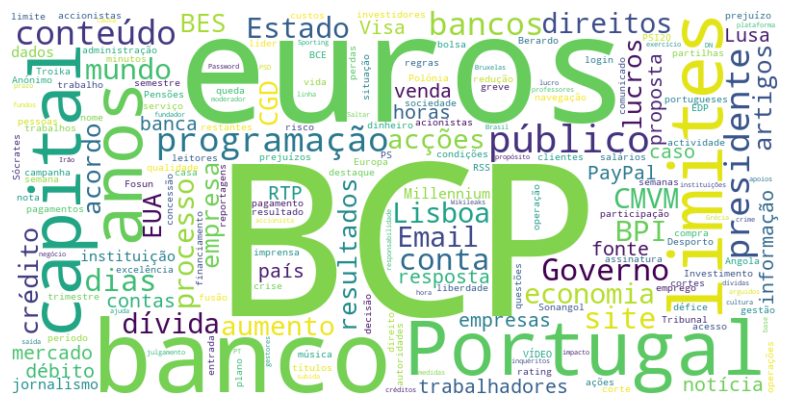

In [68]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# normalizar as contagens/pesos, tlvz fazer um logaritmo ou assim, SE valer a pena pq aparecem mt pequenas
word_freq = {word: data["count"] for word, data in df["keywords"].iloc[0].items()}

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [69]:
import plotly.graph_objects as go

# Example input dictionary

frequencias = df["keywords"].iloc[0]

# Step 1: Extract words, counts, and classes
palavras = list(frequencias.keys())
valores = [data['count'] for data in frequencias.values()]
classes = [list(data['type']) for data in frequencias.values()]


# Step 2: Define color mapping for classes
color_map = {
    'ORG': 'blue',
    'PER': 'green',
    'MISC': 'red',
    "WORD": "pink",
    "LOC": "black"
}

# Step 3: Assign colors based on class
marker_colors = [
    color_map[class_name[0]] if isinstance(class_name, list) else color_map[class_name]
    for class_name in classes
]
# Step 4: Create the bar chart
fig = go.Figure(data=[
    go.Bar(
        x=palavras,
        y=valores,
        marker_color=marker_colors,
        hovertemplate="<b>%{x}</b><br>Count: %{y}<br>Class: %{customdata}<extra></extra>",
        customdata=classes  # Adding class data for hover information
    )
])

fig.update_layout(
    title='Gráfico de Barras Interativo',
    xaxis_title='Palavras',
    yaxis_title='Frequência',
)

fig.show()


---

In [76]:
import networkx as nx
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np


# Sample dictionary data
linha = 0
data = df["keywords"].iloc[linha]
company = df.index[linha]



# Create the graph
G = nx.Graph()

# Add nodes to the graph with attributes
for word, attributes in data.items():
    G.add_node(word, **attributes)

# Add some edges for visualization
for word in data.keys():
    G.add_edge(company, word) #G.add_edges_from(list)

# Node positions
pos = nx.spring_layout(G, seed=42)

# Lists for node positions and info
node_x = []
node_y = []
node_color = []
node_text = []  # Label to show only the word
node_hovertext = []  # Detailed info for hover

for node in G.nodes:
    if node == company:
        x, y = 0, 0
        color_value = 10
        node_x.append(x)
        node_y.append(y)
        node_text.append(node)
        continue
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    
    # Color the node from red (-1) to green (1)
    color_value = G.nodes[node]["sentiment"]  # Normalize between 0 and 1
    node_color.append(f"rgb({255 * (1 - color_value)}, {255 * color_value}, 0)")
    
    # Text for label (only the word) and hover (detailed info)
    node_text.append(node)
    node_hovertext.append(
        f"""Palavra: {node}
        <br>Contagem: {G.nodes[node]['count']}
        <br>Sentiment: {round(G.nodes[node]['sentiment'], 3)}
        <br>Source: {G.nodes[node]['source']}"""
        #<br>News: {random.choice(list(G.nodes[node]['news']))} #arranjar melhor forma de fazer isto
    )

# Create the plotly figure
fig = make_subplots()

# Draw edges
edge_x = []
edge_y = []

for edge in G.edges:
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

fig.add_trace(
    go.Scatter(
        x=edge_x,
        y=edge_y,
        line=dict(width=1, color="gray"),
        hoverinfo="none",
        mode="lines"
    )
)

# Draw nodes
fig.add_trace(
    go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers+text",
        text=node_text,  # Shows only the word as label
        hovertext=node_hovertext,  # Detailed info on hover
        marker=dict(
            color=node_color,
            size=20,
            line=dict(color="black", width=1)
        ),
        hoverinfo="text"  # Use hovertext for detailed info
    )
)

# Figure layout
fig.update_layout(
    showlegend=False,
    hovermode="closest",
    margin=dict(b=0, l=0, r=0, t=0),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

fig.write_html("grafo_interativo.html")
fig.show()


In [71]:
#import webbrowser
#webbrowser.open("grafo_interativo.html")